In [130]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

# Task 1. Algorithm's analysis

In [131]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

import time
from tqdm import tqdm

### Generating graph

In [132]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

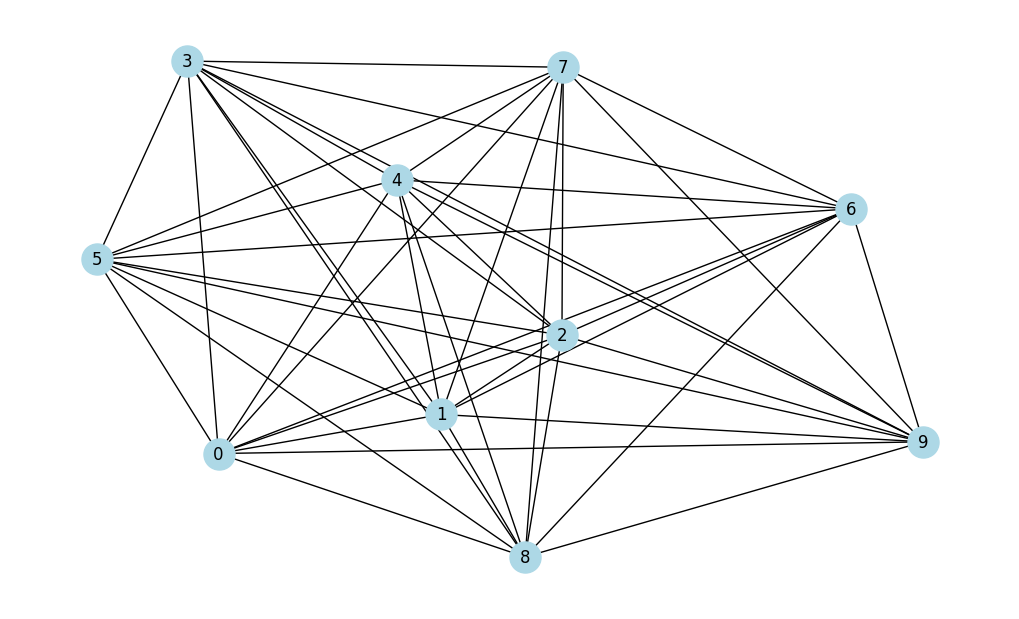

In [133]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [134]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

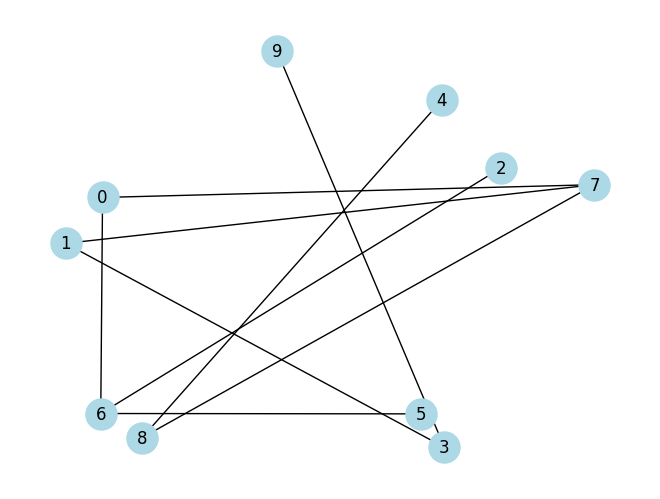

In [135]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [136]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 7), (0, 6), (1, 7), (1, 3), (2, 6), (3, 9), (4, 8), (5, 6), (7, 8)]),
 9)

In [137]:
class DSU:
    """Disjoint Set Union"""
    def __init__(self, n):
        self.father = list(range(n))
        self.height = [0] * n

    def find(self, x):
        """find root with compression"""
        if self.father[x] != x:
            self.father[x] = self.find(self.father[x])
        return self.father[x]

    def union(self, v_1, v_2):
        """union by height"""
        root_1 = self.find(v_1)
        root_2 = self.find(v_2)

        if root_1 == root_2:
            return False

        if self.height[root_1] < self.height[root_2]:
            self.father[root_1] = root_2
        elif self.height[root_1] > self.height[root_2]:
            self.father[root_2] = root_1
        else:
            self.father[root_2] = root_1
            self.height[root_1] += 1
        return True


def kruskal_algorithm(graph):
    """
    Kruskal's algorithm. Find Minimum Spanning Tree(MST).
    Uses DSU for cycle detection
    """
    nodes = list(graph.nodes())
    edges = []

    # all edges
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        edges.append((weight, u, v))

    edges.sort()

    # node: index
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    dsu = DSU(len(nodes))
    mst_edges = []

    for weight, u, v in edges:
        # different components
        if dsu.union(node_to_idx[u], node_to_idx[v]):
            mst_edges.append((u, v, weight))
            # n-1 edge
            if len(mst_edges) == len(nodes) - 1:
                break
    return mst_edges

### Prim's algorithm

#### nx implementation

In [138]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

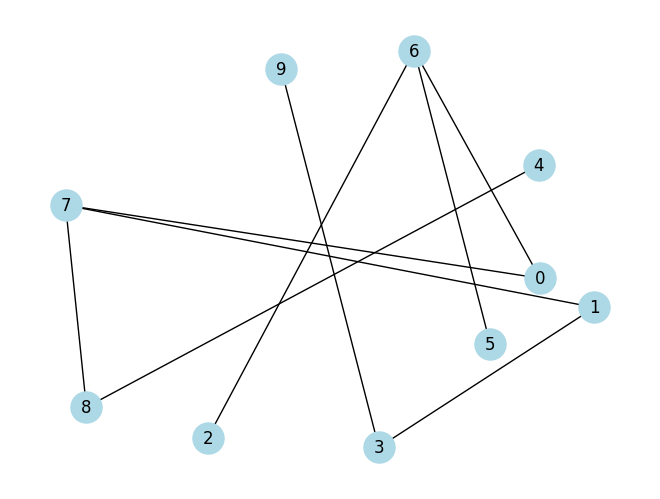

In [139]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [140]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 7), (0, 6), (1, 7), (1, 3), (2, 6), (3, 9), (4, 8), (5, 6), (7, 8)]),
 9)

In [141]:
def prim_algorithm(graph):
    nodes = list(graph.nodes())
    if not nodes:
        return []


    starting_node = nodes[0]

    visited_nodes = {starting_node}
    the_edges = []

    while len(visited_nodes) < len(nodes):
        min_weight = float("inf")
        best_edge = None

        for u in visited_nodes:
            for v, info in graph[u].items():
                if v not in visited_nodes:
                    weight = info.get("weight", 1)
                    if weight < min_weight:
                        min_weight = weight
                        best_edge = (u, v, weight)

        if best_edge:
            visited_nodes.add(best_edge[1])
            the_edges.append(best_edge)
        else:
            break

    return the_edges


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# **Experiments: Prim / Kruskal**



In [142]:
GRAPH_SIZES = [5, 10, 20, 50, 100, 200, 500]
COMPLETENESS = 0.4
ITERATIONS = 30

# Measure Prim vs Kruskal
prim_times = []
kruskal_times = []
nx_prim_times = []
nx_kruskal_times = []

for n in GRAPH_SIZES:
    prim_total = 0
    kruskal_total = 0
    nx_prim_total = 0
    nx_kruskal_total = 0

    for _ in tqdm(range(ITERATIONS), desc=f'size {n}'):

        G = gnp_random_connected_graph(n, COMPLETENESS, False)

        # Our Prim
        start = time.time()
        prim_algorithm(G)
        prim_total += time.time() - start

        # Our Kruskal
        start = time.time()
        kruskal_algorithm(G)
        kruskal_total += time.time() - start

        # NetworkX Prim
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="prim")
        nx_prim_total += time.time() - start

        # NetworkX Kruskal
        start = time.time()
        tree.minimum_spanning_tree(G, algorithm="kruskal")
        nx_kruskal_total += time.time() - start

    prim_times.append(prim_total / ITERATIONS)
    kruskal_times.append(kruskal_total / ITERATIONS)
    nx_prim_times.append(nx_prim_total / ITERATIONS)
    nx_kruskal_times.append(nx_kruskal_total / ITERATIONS)


size 500: 100%|██████████| 30/30 [04:08<00:00,  8.29s/it]


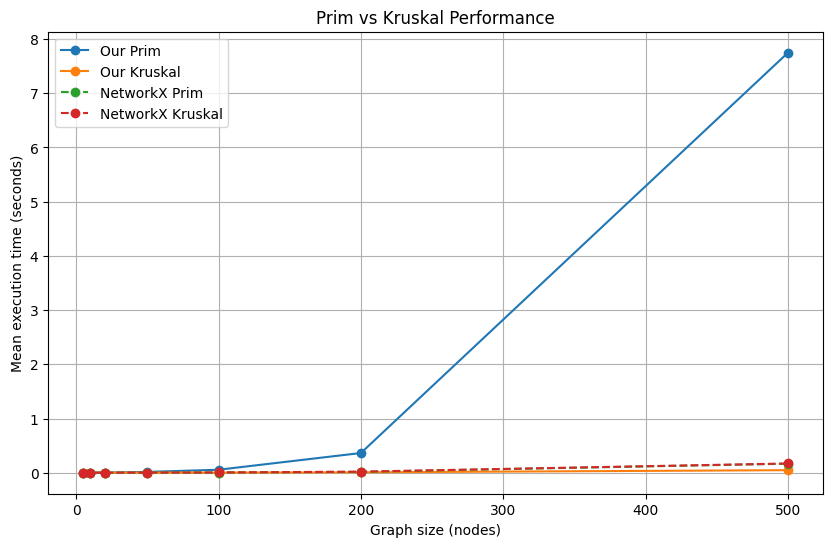

In [143]:
plt.figure(figsize=(10,6))

plt.plot(GRAPH_SIZES, prim_times, marker='o', label="Our Prim")
plt.plot(GRAPH_SIZES, kruskal_times, marker='o', label="Our Kruskal")
plt.plot(GRAPH_SIZES, nx_prim_times, marker='o', linestyle='--', label="NetworkX Prim")
plt.plot(GRAPH_SIZES, nx_kruskal_times, marker='o', linestyle='--', label="NetworkX Kruskal")

plt.xlabel("Graph size (nodes)")
plt.ylabel("Mean execution time (seconds)")
plt.title("Prim vs Kruskal Performance")
plt.legend()
plt.grid()
plt.show()


**Висновки по Prim і Kruskal**

Наш Prim показав значно більший час виконання, ніж інші алгоритми.
Причина - у нашій реалізації ми на кожному кроці перебираємо всі ребра, що ведуть з уже відвіданих вузлів, щоб знайти мінімальне.
Тобто складність у найгіршому випадку буде +- до O(V^2) для щільного графа ( багато ребер). Через це на великих графах (100–200 вузлів) час росте дуже швидко, що і видно на графіку.
Ми зрозуміли що для прискорення треба використовувати heap, як це робить NetworkX, тоді складність зменшиться і час стане порівнянним з Kruskal.

Наш Kruskal працює швидко і стабільно навіть на великих графах.
Саме завдяки імплементації DSU для перевірки циклів - ми уникаємо зайвих ітерацій і швидко визначаємо, чи можна додати ребро.

NetworkX теж використовує оптимізації, але наша реалізація DSU із union-by-rank і path compression працює ефективно на цих розмірах.
NetworkX Prim і Kruskal показують очікувано низький час виконання.


## Subtask 1.2 (1 point)

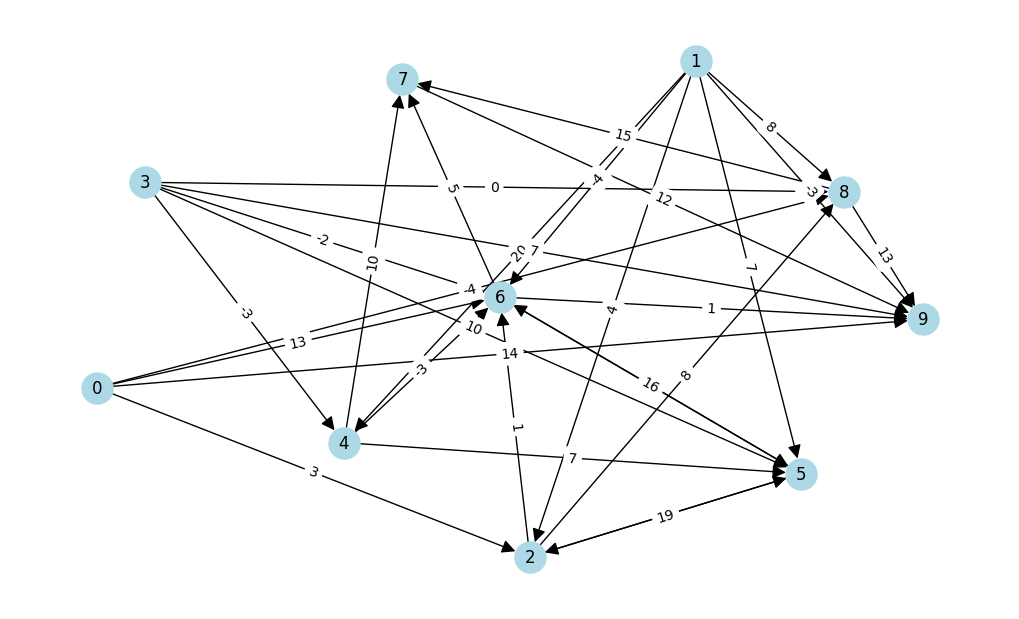

In [144]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [145]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 9: 5
Distance to 2: 3
Distance to 6: 4
Distance to 8: -4
Distance to 5: 14
Distance to 7: 9


In [146]:
def bellman_ford_algorithm(graph, source):
    """
    Bellman-Ford algorithm for finding shortest paths from source vertex

    Time complexity: O(V * E) where V is vertices, E is edges
    Returns: (distances, predecessors) or raises error if negative cycle exists
    """
    nodes = list(graph.nodes())
    distances = {node: float('inf') for node in nodes}
    predecessors = {node: None for node in nodes}
    distances[source] = 0

    # Relax edges |V| - 1 times
    for _ in range(len(nodes) - 1):
        for u, v, data in graph.edges(data=True):
            weight = data.get('weight', 1)
            if distances[u] != float('inf') and distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                predecessors[v] = u

    # Check for negative cycles
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1)
        if distances[u] != float('inf') and distances[u] + weight < distances[v]:
            raise ValueError("Graph contains a negative-weight cycle")

    return predecessors, distances

### Floyd-Warshall algorithm

#### nx implementation

In [147]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 9: 5, 2: 3, 6: 4, 8: -4, 1: inf, 3: inf, 4: inf, 5: 14, 7: 9}
Distances with 1 source: {1: 0, 5: 7, 2: 4, 4: 20, 6: -4, 8: 8, 9: -3, 0: inf, 3: inf, 7: 1}
Distances with 2 source: {2: 0, 5: 11, 6: 1, 8: 8, 0: inf, 1: inf, 3: inf, 4: inf, 7: 6, 9: 2}
Distances with 3 source: {3: 0, 6: -6, 4: -3, 5: 4, 8: 0, 9: -5, 0: inf, 1: inf, 2: 23, 7: -1}
Distances with 4 source: {4: 0, 5: 7, 6: -3, 7: 2, 0: inf, 1: inf, 2: 26, 3: inf, 8: 34, 9: -2}
Distances with 5 source: {5: 0, 2: 19, 6: 6, 0: inf, 1: inf, 3: inf, 4: inf, 7: 11, 8: 27, 9: 7}
Distances with 6 source: {6: 0, 5: 16, 9: 1, 7: 5, 0: inf, 1: inf, 2: 35, 3: inf, 4: inf, 8: 43}
Distances with 7 source: {7: 0, 9: 12, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 8: inf}
Distances with 8 source: {8: 0, 7: 15, 9: 13, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf}
Distances with 9 source: {9: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf, 8: inf}


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

**Перевірка чи детектяться від'ємні цикли**

In [148]:
G_neg = nx.DiGraph()
G_neg.add_edge(0, 1, weight=-1)
G_neg.add_edge(1, 2, weight=-2)
G_neg.add_edge(2, 0, weight=-3)

print("\n\n\n\n\nТест на від'ємний цикл:\n")
try:
    bellman_ford_algorithm(G_neg, 0)
except ValueError as e:
    print("Наш BF:", e)

try:
    bellman_ford_predecessor_and_distance(G_neg, 0)
except Exception as e:
    print("NetworkX BF:", e)






Тест на від'ємний цикл:

Наш BF: Graph contains a negative-weight cycle
NetworkX BF: Negative cycle detected.


size 200: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it]


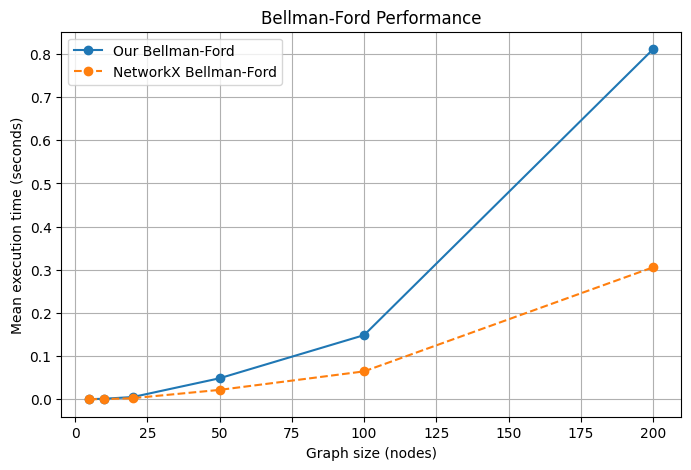

In [156]:
SIZES = [5, 10, 20, 50, 100, 200]
NUM_OF_ITERATIONS = 50

our_times = []
nx_times = []

for n in SIZES:
    our_total = 0
    nx_total = 0

    for _ in tqdm(range(NUM_OF_ITERATIONS), desc=f"size {n}"):

        G = gnp_random_connected_graph(n, 0.4, directed=True)

        # Our Bellman-Ford
        start = time.time()
        try:
            bellman_ford_algorithm(G, 0)
        except ValueError:
            pass  # negative cycle
        end = time.time()
        our_total += (end - start)

        # NetworkX Bellman-Ford
        start = time.time()
        try:
            bellman_ford_predecessor_and_distance(G, 0)
        except:
            pass
        end = time.time()
        nx_total += (end - start)

    our_times.append(our_total / NUM_OF_ITERATIONS)
    nx_times.append(nx_total / NUM_OF_ITERATIONS)


plt.figure(figsize=(8,5))
plt.plot(SIZES, our_times, marker='o', label="Our Bellman-Ford")
plt.plot(SIZES, nx_times, marker='o', linestyle='--', label="NetworkX Bellman-Ford")

plt.xlabel("Graph size (nodes)")
plt.ylabel("Mean execution time (seconds)")
plt.title("Bellman-Ford Performance")
plt.legend()
plt.grid(True)
plt.show()

**Висновки по “BelmanFord”**


Наш Bellman/Ford показав помітно більший час виконання, ніж реалізація NetworkX, і різниця швидко росте зі збільшенням розміру графа. Наскільки ми зрозуміли причина цього - сама природа алгоритму: у нашій реалізації ми виконуємо релаксацію всіх ребер V−1 разів. Тобто складність алгоритму становить
O(V * E), тому коли граф стає більшим (особливо якщо він досить щільний), кількість операцій різко зростає. Саме тому на графах 100–200 вузлів час виконання починає рости швидко(видно на графіку)

Наша реалізація працює коректно і стабільно - алгоритм правильно знаходить найкоротші шляхи навіть при наявності від’ємних ваг, а також правильно визначає від’ємні цикли. Основний час втрачається саме на багаторазову релаксацію ребер і тут ми не знайшли можливості суттєво зменшити складність без зміни самого алгоритму.

NetworkX Bellman–Ford працює швидше, але різниця не така радикальна, як у випадку з Prim. NetworkX має оптимізовані структури даних, тому має кращі результати по часу.

Підсумовуючи, BellmanFord значно повільніший за MST алгоритми які ми реалізували (Prim і Kruskal), але його головна перевага це підтримка від’ємних ваг і можливість виявлення від’ємних циклів.

# Task 2. Decision Tree Classifier

In [ ]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn import tree as sklearn_tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


In [ ]:
def gini(y: npt.NDArray) -> float:
    if len(y) == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities ** 2)

In [ ]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray, num_classes=None, alpha=0.0):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

        if len(y) > 0:
            if alpha > 0.0 and num_classes is not None:
                counts = np.bincount(y, minlength=num_classes).astype(float)
                smoothed_probs = (counts + alpha) / (len(y) + alpha * num_classes)
                self.value = int(np.argmax(smoothed_probs))
                self.probs = smoothed_probs
            else:
                self.value = int(np.bincount(y).argmax())
                self.probs = None
        else:
            self.value = 0
            self.probs = None

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int, alpha=0.0) -> None:
        self.max_depth = max_depth
        self.alpha = alpha
        self.tree = None
        self.number_of_classes = None


    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = int(np.unique(y).size)
        self.tree = self._grow_tree(X, y, depth=0)


    def _grow_tree(self, X, y, depth):
        node = Node(X, y, num_classes=self.number_of_classes, alpha=self.alpha)

        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_labels == 1 or num_samples < 2:
            return node

        best_split = self._best_split(X, y, num_features)
        if not best_split:
            return node

        node.feature_index = best_split['feature_idx']
        node.threshold = best_split['threshold']

        node.left = self._grow_tree(
            X[best_split['left_indices']],
            y[best_split['left_indices']],
            depth + 1
        )
        node.right = self._grow_tree(
            X[~best_split['left_indices']],
            y[~best_split['left_indices']],
            depth + 1
        )
        return node


    def _best_split(self, X, y, num_features):
        """
        Iterates through all features and thresholds to find the optimal split
        """
        best_gini = float('inf')
        best_split = None

        for feature_idx in range(num_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] < threshold
                if np.sum(left_mask) == 0 or np.sum(~left_mask) == 0:
                    continue

                gini_l = gini(y[left_mask])
                gini_r = gini(y[~left_mask])
                len_l, len_r = len(y[left_mask]), len(y[~left_mask])
                weighted_gini = (len_l * gini_l + len_r * gini_r) / len(y)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_indices': left_mask
                    }
        return best_split


    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child and return the predicted class for it
        """
        predictions = []
        for x in X_test:
            node = self.tree
            while node.left:
                if x[node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.value)

        return predictions

In [ ]:

def evaluate(X_test: list[list], y_test: list, tree) -> float:
    predictions = tree.predict(X_test)
    correct = sum(p == t for p, t in zip(predictions, y_test))
    return correct / len(y_test)

**Laplace Smoothing**

У звичайному дереві рішень вузол просто вибирає клас, якого більше (argmax). Але якщо в листі опинилося всього 1–2 приклади, модель стає занадто самовпевненою в результаті на основі малої вибірки. І це веде до перенавчання.

Щоб це виправити, ми використали згладжування Лапласа. Його суть — додати невелику константу альфа (зазвичай 1) до лічильника кожного класу. Формула виглядає так: P= (count + альфа) / ( N+ альфа⋅K)
​
 .

Це дає два плюси:

- Ми уникаємо нульових ймовірностей.

- Якщо даних у вузлі мало, розподіл ймовірностей стає більш рівномірним, і модель не приймає поганих рішень (на великих вибірках це майже не впливає на результат).


**Результат:**

In [ ]:
data = load_iris()
X, y = data.data, data.target

results = {"depth": [], "no_smoothing": [], "laplace": [], "sklearn": []}

for depth in range(1, 9):
    scores_no = []
    scores_la = []
    scores_sk = []

    for seed in range(20):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        # Наш DTC без Laplace
        m1 = DecisionTreeClassifier(max_depth=depth, alpha=0.0)
        m1.fit(X_train, y_train)
        scores_no.append(evaluate(X_test, y_test, m1))

        # Наш DTC з Laplace (альфа=1)
        m2 = DecisionTreeClassifier(max_depth=depth, alpha=1.0)
        m2.fit(X_train, y_train)
        scores_la.append(evaluate(X_test, y_test, m2))

        # sklearn
        m3 = SklearnDTC(max_depth=depth)
        m3.fit(X_train, y_train)
        scores_sk.append(m3.score(X_test, y_test))

    results["depth"].append(depth)
    results["no_smoothing"].append(np.mean(scores_no))
    results["laplace"].append(np.mean(scores_la))
    results["sklearn"].append(np.mean(scores_sk))

plt.figure(figsize=(9, 5))
plt.plot(results["depth"], results["no_smoothing"], label="Our DTC (no smoothing)")
plt.plot(results["depth"], results["laplace"], label="Our DTC (Laplace a=1)")
plt.plot(results["depth"], results["sklearn"], label="sklearn DTC")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (avg over 20 splits)")
plt.title("Effect of Laplace Smoothing vs Depth (Iris)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("dtc_laplace_comparison.png", dpi=150)
plt.show()

print("\n Результати (avg accuracy)")
print(f"{'depth':>5}  {'no smooth':>10}  {'laplace':>10}  {'sklearn':>10}")
for i, d in enumerate(results["depth"]):
    print(f"{d:>5}  {results['no_smoothing'][i]:>10.4f}  "
            f"{results['laplace'][i]:>10.4f}  {results['sklearn'][i]:>10.4f}")

# max_depth=3
print("\n Демо: max_depth=3, один спліт")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_plain   = DecisionTreeClassifier(max_depth=3, alpha=0.0)
clf_laplace = DecisionTreeClassifier(max_depth=3, alpha=1.0)
clf_plain.fit(X_train, y_train)
clf_laplace.fit(X_train, y_train)

acc_plain   = evaluate(X_test, y_test, clf_plain)
acc_laplace = evaluate(X_test, y_test, clf_laplace)
print(f"Точність без Laplace : {acc_plain:.4f}")
print(f"Точність з Laplace a=1    : {acc_laplace:.4f}")

**Висновок по Decision Tree**


Різниці в accuracy ми майже не помітили, бо Iris — занадто хороший(чистий) датасет для перевірки згладжування. Але теоретично сама ідея згладжування Лапласа мала б бути правильною, тому що вона не дає дереву бути занадто радикальним, коли в листі мало даних. Без згладжування модель просто видає ймовірність 1.0 для класу, навіть якщо там один приклад, а це неправильно. Параметр альфа не дає дереву приймати категоричні рішення на основі 1–2 прикладів

**Висновки**

Виконуючи цю лаболаторну ми зіштовхнулися з певними складностями, та купою матеріалу який прийшлося проаналізувати та осмислити для того щоб реалізувати алгоритми, а особливо щоб реалізувати дерево рішень. Це однозначно дозволило нам краще зрозуміти саме механіку, а не просто алгоритм дій який ми використовували на лекціях.

Хоча не всі наші функції (особливо Прима) працюють швидше за професійні бібліотеки, ми реалізували їх. DSU - значно покращив роботу алгоритму Краскала. А smoothing для дерева рішень не показав такиж кардинальних покращень, але теоретично є логічним вдосконаленням(оптимізацією).